In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver
    
import discretize
from discretize.utils import mkvc

from SimPEG import (
    maps,
    data,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
    utils
)
from SimPEG.electromagnetics import frequency_domain as fdem

import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model

In [26]:
write_output = False

## Setup 3D Model

In [27]:
resistivity_surface = 1000
resistivity_middle = 10
resistivity_deep = 100
resistivity_air = 1e8

## Forward Modelling Mesh

the mesh has 4368 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_19820\331272648.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_19820\331272648.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

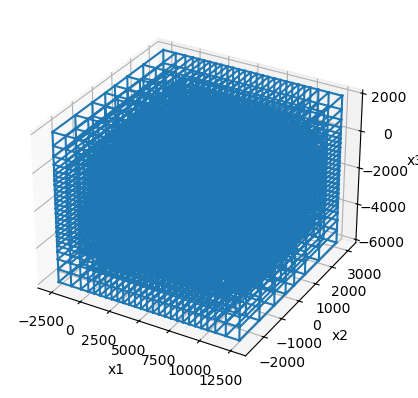

In [28]:
csx = 500  # cell size for the horizontal direction
csz = 250  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 3  # number of padding cells in the x-direction
npady = 3  # number of padding cells in the y-direction
npadz = 4  # number of padding cells in the z-direction

core_domain_x = np.r_[0, 10000]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-4000, 0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0][: npadx].sum(), -mesh.h[1][: npady].sum(), -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

In [ ]:
# Save the mesh
# mesh.save(file_name="3d_mesh.json")

## 2D Inversion Mesh

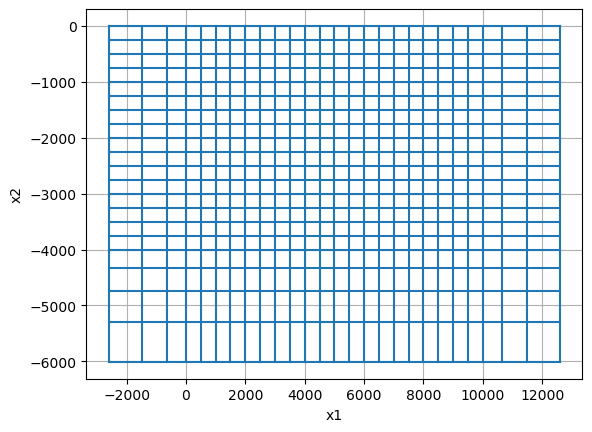

In [29]:
inversion_mesh_2d = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh_2d.x0 = [-inversion_mesh_2d.h[0][mesh.cell_centers_x <= 0].sum(), -inversion_mesh_2d.h[1].sum()]
ax = inversion_mesh_2d.plot_grid()

In [7]:
#save the inversion mesh
# inversion_mesh_2d.save(file_name="inversion_mesh_2d.json")

## Mapping

In [30]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, resistivity_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh_2d.nC
    )
)

## 1D Inversion Mesh

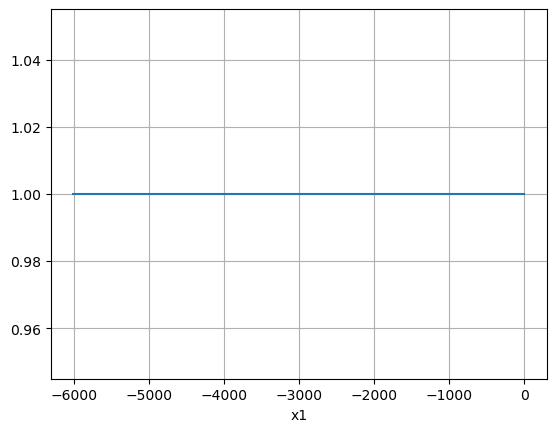

In [31]:
inversion_mesh_1d = discretize.TensorMesh([mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh_1d.x0 = [-inversion_mesh_1d.h[0].sum()]
ax = inversion_mesh_1d.plot_grid()

In [ ]:
# Save mesh
# inversion_mesh_1d.save(file_name="./mesh/inversion_mesh_1d.json")

In [32]:
mesh1D = discretize.TensorMesh([mesh.h[2]], x0=mesh.x0[[2]])
active_inds_1d = mesh1D.gridCC[:] < 0  # active indices are below the surface
mapping_1d = (
    maps.SurjectVertical1D(mesh)
    *maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh1D, active_inds_1d, resistivity_air
    )
    *maps.ExpMap(nP=inversion_mesh_1d.nC)
    )

## True Model

In [33]:
# Define interface parameters
interfaces = [
    {
        'z_shallow': -500,
        'z_deep': -1000,
        'x_dip': np.r_[5000, 9000]
    },
    {
        'z_shallow': -1000,
        'z_deep': -2500,
        'x_dip': np.r_[2000, 7000]
    }
]

In [34]:
def interface(x, inferfaces=interfaces):

    boundaries = []
    for i, keys in enumerate(interfaces):
        z1, z2, x_dip = keys.values()
        temp = np.zeros_like(x)
        if i ==0:
            temp[x < x_dip[0]] = z1
        dipping_unit = (x >= x_dip[0]) & (x <= x_dip[1])
        x_dipping = (-(z1 - z2) / (x_dip[1]- x_dip[0])) * x[dipping_unit]
        x_dipping = x_dipping - x_dipping[0] + z1
        temp[dipping_unit] = x_dipping
        temp[x > x_dip[1]] = z2
        boundaries.append(temp)

    return boundaries[0], boundaries[1]

(-4000.0, 0.0)

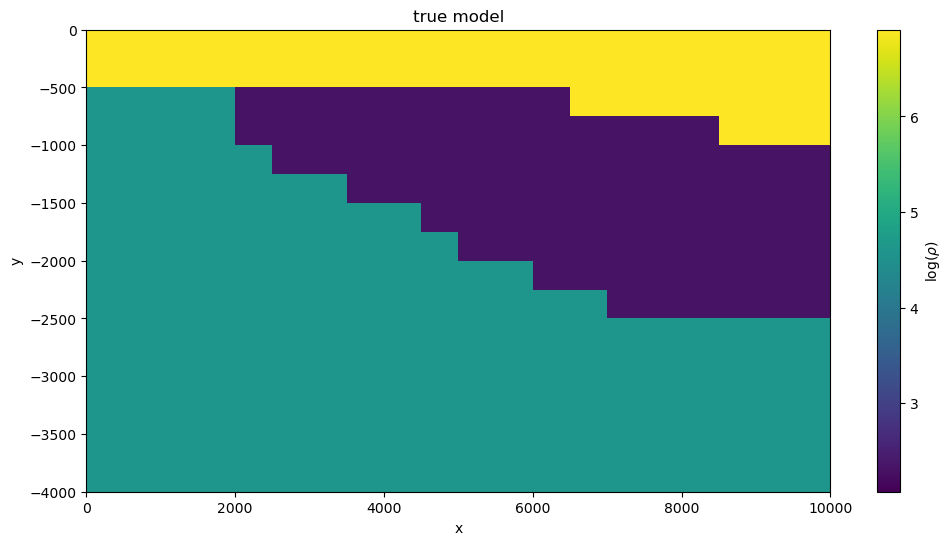

In [35]:
m_true = np.log(resistivity_deep) * np.ones(inversion_mesh_2d.nC)
interface_1, interface_2 = interface(inversion_mesh_2d.gridCC[:, 0])
m_true[inversion_mesh_2d.gridCC[:, 1] > interface_2] = np.log(resistivity_middle)
m_true[inversion_mesh_2d.gridCC[:, 1] > interface_1] = np.log(resistivity_surface)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
clim = np.r_[np.log(1000), np.log(10)]
cb = plt.colorbar(inversion_mesh_2d.plot_image(m_true, ax=ax, clim=clim)[0], ax=ax)
cb.set_label(r"$\log(\rho)$")
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])
# ax.minorticks_on()
# ax.grid(True, color='k', which="both")

In [19]:
# save model
# np.save('models/2d-model-array.npy', m_true)

## 1D Data Collection (1DLayered)

In [12]:
frequencies = np.logspace(-4, 6, 15)

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + 10, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

dpreds = []

# Each unique location and frequency defines a new transmitter
for ii in range(ntx):
    source_list = [] 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 1
            )
        )

    # create the survey and problem objects for running the forward simulation
    survey = fdem.Survey(source_list)
    layer_thicknesses, log_resistivity_map, log_resistivity_model, _ = get_1d_model(source_locations[ii, 0])
    sim = fdem.Simulation1DLayered(
        survey=survey,
        thicknesses=layer_thicknesses,
        rhoMap=log_resistivity_map,
    )
    dpreds.append(sim.dpred(log_resistivity_model))


### Plot 1d data for a certain location

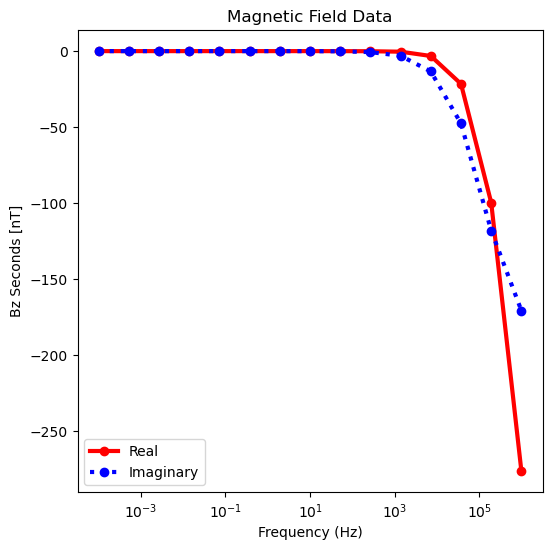

In [15]:
location_index = 0
d  = dpreds[location_index]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, (10**9)*d[0::2], "r-o", lw=3)
ax.semilogx(frequencies, (10**9)*d[1::2], "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bz Seconds [nT]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()


### Save Data

In [16]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.00 # Change this

    data = []

    for d in dpreds:
        noise = noise_level * np.abs(d) * np.random.rand(len(d))
        d += noise
        data.append(d[0::2]) # add real data
        data.append(d[1::2]) # add imaginary data
    
    fname = os.path.join(dir_path, "em3dfm_1d_data_1DLayered.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, *data], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )

## 3D Data Collection

In [10]:
frequencies = np.logspace(-4, 6, 15)

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + 10, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter
for ii in range(ntx): 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 100
            )
        )
        
# create the survey and problem objects for running the forward simulation
survey = fdem.survey.Survey(source_list)
prob = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, rhoMap=mapping, solver=Solver
)

In [11]:
dpred = prob.dpred(m_true)

In [ ]:
# Data are organized by transmitter location, then component, then frequency. We had nFreq
# transmitters and each transmitter had 2 receivers (real and imaginary component). So
# first we will pick out the real and imaginary data
bz_real = dpred[0 : len(dpred) : 2]
bz_imag = dpred[1 : len(dpred) : 2]

# Then we will will reshape the data.
bz_real = np.reshape(bz_real, (ntx, len(frequencies)))
bz_imag = np.reshape(bz_imag, (ntx, len(frequencies)))

# Plot FEM response for all frequencies
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.2, 0.15, 0.75, 0.75])
location_index = 15
ax1.semilogx(frequencies, bz_real[location_index, :], "r-", lw=3)
ax1.semilogx(frequencies, bz_imag[location_index, :], "b--", lw=3)
ax1.set_xlim((np.min(frequencies), np.max(frequencies)))
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Bz secondary [nT]")
ax1.set_title("Response at Smallest Offset")
ax1.legend(["Real", "Imaginary"], loc="upper left")

In [ ]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.00 # Change this
    noise = noise_level * np.abs(dpred) * np.random.rand(len(dpred))
    dpred_noisy = dpred + noise

    bz_real = dpred_noisy[0 : len(dpred) : 2]
    bz_imag = dpred_noisy[1 : len(dpred) : 2]

    # Then we will will reshape the data.
    bz_real = np.reshape(bz_real, (ntx, len(frequencies)))
    bz_imag = np.reshape(bz_imag, (ntx, len(frequencies)))

    fname = os.path.join(dir_path, "em3dfm_3d_data.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, bz_real.T, bz_imag.T], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )

In [12]:
uncertainties = 0.01 * np.abs(dpred) * np.ones(np.shape(dpred))

In [13]:
data_object = data.Data(survey, dobs=dpred, noise_floor=uncertainties)

In [48]:
# estimated host conductivity (S/m)
estimated_resistivity = 100

# minimum skin depth
d_min = 500.0 * np.sqrt(estimated_resistivity/ frequencies.max())
print("MINIMUM SKIN DEPTH: {} m".format(d_min))

# maximum skin depth
d_max = 500.0 * np.sqrt(estimated_resistivity/ frequencies.min())
print("MAXIMUM SKIN DEPTH: {} m".format(d_max))

MINIMUM SKIN DEPTH: 5.0 m
MAXIMUM SKIN DEPTH: 500000.0 m


In [28]:
dmisfit = data_misfit.L2DataMisfit(simulation=prob, data=data_object)
reg = regularization.WeightedLeastSquares(inversion_mesh_2d)
opt = optimization.InexactGaussNewton(maxIterCG=10, maxIterLS=100)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

betaest = directives.BetaEstimate_ByEig(beta0_ratio=1e-2)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=5)
target = directives.TargetMisfit()

directiveList = [betaest, target]
inv = inversion.BaseInversion(invProb, directiveList=directiveList)

In [29]:
m0 = np.log(estimated_resistivity) * np.ones(inversion_mesh_2d.nC)
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticFluxDensity problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.36e-02  1.15e+07  0.00e+00  1.15e+07    6.09e+06      0              
   1  2.36e-02  9.71e+06  7.28e+04  9.71e+06    2.65e+06      5              
   2  2.

: 

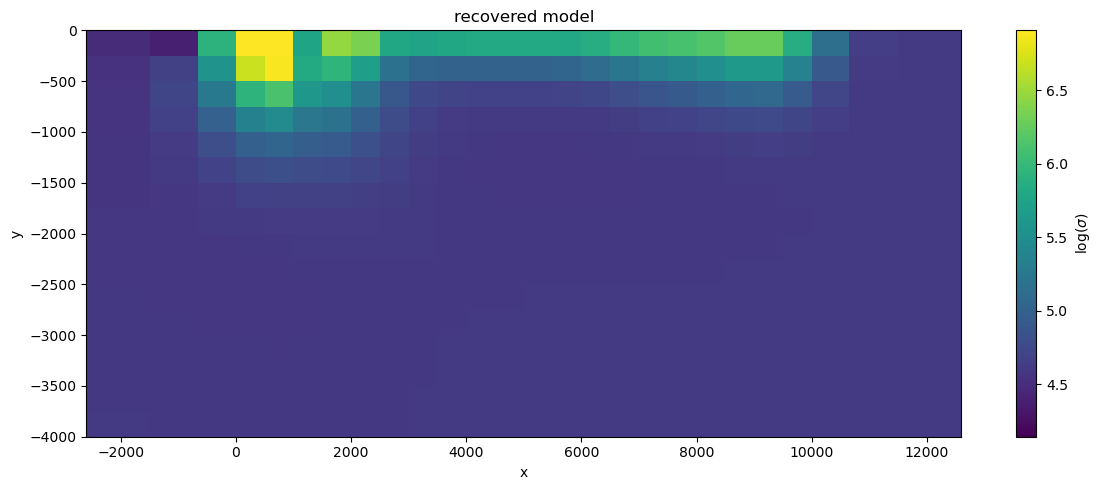

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# put both plots on the same colorbar
clim = np.r_[np.log(1000), np.log(100)]

# recovered model
cb = plt.colorbar(
    inversion_mesh_2d.plot_image(mrec, ax=ax, clim=clim)[0],
    ax=ax,
)
ax.set_title("recovered model")
cb.set_label(r"$\log(\sigma)$")

ax.set_ylim([-4000, 0])

plt.tight_layout()
plt.show()

## 1D Data Collection (3DMagneticFluxDensity)

In [38]:
frequencies = np.logspace(-4, 6, 15)

x_positions = np.arange(0, 10000, 500)

# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(x_positions, [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(x_positions + 10, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

dpreds = []
# Each unique location and frequency defines a new transmitter
for ii in range(ntx): 
    source_list = [] 
    # Define receivers of different type at each location
    bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "real"
    )

    bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_locations[ii, :], "z", "imag"
    )
    receivers_list = [bzr_receiver, bzi_receiver]
    for jj in range(len(frequencies)):
        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[jj],
                source_locations[ii, :],
                orientation="z",
                momemt = 100
            )
        )
    l_,_,_, z_values_model = get_1d_model(source_locations[ii, 0],m_true=m_true, inversion_mesh_2d=inversion_mesh_2d)
    
    # create the survey and problem objects for running the forward simulation
    survey = fdem.survey.Survey(source_list)
    prob = fdem.Simulation3DMagneticFluxDensity(
        mesh, survey=survey, rhoMap=mapping_1d, solver=Solver
    )
    dpreds.append(prob.dpred(z_values_model))

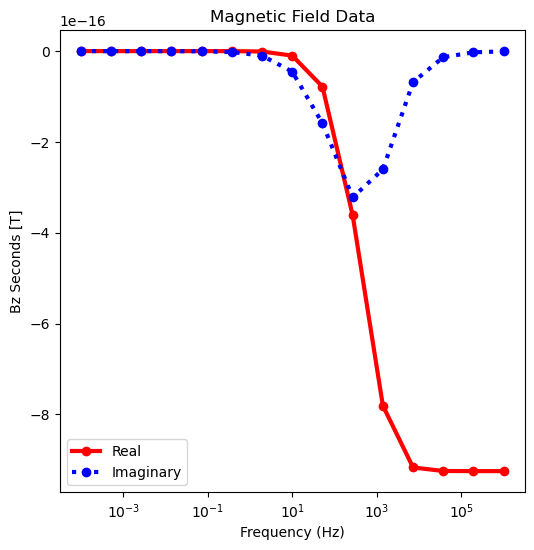

In [47]:
location_index = 9
d  = dpreds[location_index]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogx(frequencies, d[0::2], "r-o", lw=3)
ax.semilogx(frequencies, d[1::2], "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Bz Seconds [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.show()

### Save Data

In [ ]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "3d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.00 # Change this

    data = []

    for d in dpreds:
        noise = noise_level * np.abs(d) * np.random.rand(len(d))
        d += noise
        data.append(d[0::2]) # add real data
        data.append(d[1::2]) # add imaginary data
    
    fname = os.path.join(dir_path, "em3dfm_1d_data_3dMagFluxDens.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, *data], #needed to modify this line
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )

In [50]:
import sys
sys.path.append("../")
from inversion_toolkit.model_functions import get_1d_model, generate_survey

In [49]:
location_index=0
uncertainties = 0.01 * np.abs(dpreds[location_index]) * np.ones(np.shape(dpreds[location_index]))
survey = generate_survey(frequencies=frequencies, x_position=x_positions[location_index], moment=100)
prob = fdem.Simulation3DMagneticFluxDensity(
        mesh, survey=survey, rhoMap=mapping_1d, solver=Solver
    )

In [77]:
data_object = data.Data(survey, dobs=dpreds[location_index], noise_floor=uncertainties)
dmisfit = data_misfit.L2DataMisfit(simulation=prob, data=data_object)
reg = regularization.WeightedLeastSquares(
    inversion_mesh_1d,
    length_scale_x=10.0,
    reference_model= np.log(estimated_resistivity) * np.ones(inversion_mesh_1d.nC),
    reference_model_in_smooth=False,
    )
opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=50, maxIterCG=20, tolCG=1e-3
    )
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)

# update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=0.05)
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directiveList = [
                starting_beta, 
                beta_schedule, 
                target_misfit
                ]

inv = inversion.BaseInversion(invProb, directiveList=directiveList)

In [78]:
m0 = np.log(estimated_resistivity) * np.ones(inversion_mesh_1d.nC)
mrec = inv.run(m0)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticFluxDensity problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.73e-02  6.71e+03  0.00e+00  6.71e+03    3.63e+03      0              
   1  6.73e-02  4.92e+03  1.21e+03  5.00e+03    1.51e+03      0              
   2  6.73e-02  4.43e+03  1.20e+03  4.51e+03    7.48e+02      6              
   3  1.35e-02  3.77e+03  1.18e+03  3.78e+03    1.17e+03      5              
------------------------------------------------------------------
0 :    ft     = 1.4720e+04 <= alp*descent     = 3.7844e+03
1 : maxIterLS =      50    <= iterLS          =    